In [2]:
from reproducibility import *

# Variance Estimation Experiment

In [3]:
dataset = AlignExperiment.load("statephate_updated_x_t_same_size")

Args: {'data_dir': 'statephate', 'log_dir': 'statephate/model', 'config': None, 'wandb_id': None, 'wandb_entity': 'sb-paired', 'wandb_project': None, 'run_name': 'pkzialojs', 'online': False, 'dataset': 'statephate', 'n_samples': 10000, 'train_bs': 32, 'val_bs': 8, 'transform': None, 'split_fracs': [0.8, 0.1, 0.1], 'num_workers': 1, 'in_dim': 50, 'out_dim': 50, 'timestep_emb_dim': 128, 'h_dim': 128, 'n_layers': 3, 'activation': 'silu', 'dropout_p': 0.1, 'n_epochs': 30, 'use_grad_noise': False, 'drift_weight': 1.0, 'reg_weight': 1.0, 'diffusivity_schedule': 'constant', 'max_diffusivity': 1.0, 'use_drift_in_doobs': True, 'optim_name': 'adam', 'lr': 0.001, 'weight_decay': 0.001, 'grad_clip_value': 1.0, 'scheduler': 'plateau', 'scheduler_mode': 'min', 'ema_decay_rate': 0.999, 'log_every': 1000, 'eval_every': 10000, 'inference_every': 0, 'inference_steps': 100, 'inference_metric': 'val_rmsd', 'inference_goal': 'min', 'early_stop_metric': 'val_loss', 'early_stop_goal': 'min'}


In [4]:
proj_tranfs = joblib.load("../data/statephate/statephate_2pca.joblib").transform

def project(x):
    x = np.nan_to_num(x)
    if len(x.shape) == 3:
        return np.stack(list(map(proj_tranfs, x)), axis=0)
    return proj_tranfs(x)

/home/ubuntu/anaconda3/envs/sb_paired/lib/python3.7/site-packages/sklearn/base.py:338: UserWarning: Trying to unpickle estimator PCA from version 1.2.1 when using version 1.0.2. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/modules/model_persistence.html#security-maintainability-limitations
  UserWarning,


In [5]:
def conditional_sampling(pos_0, pos_T, model, g, inference_steps, t_schedule):
    pos = pos_0.clone()
    model.eval()

    pos_T = pos_T.clone().to(DEVICE)

    trajectory = np.zeros((inference_steps+1, *pos_0.shape))
    trajectory[0] = pos.cpu()

    dt = t_schedule[1] - t_schedule[0]

    with torch.no_grad():
        for t_idx in range(1, inference_steps+1):
            t = t_schedule[t_idx]

            drift_pos = model.run_drift(pos, torch.ones(pos.shape[0]).to(DEVICE)* t)
            drift_pos = drift_pos + model.run_doobs_score(pos, pos_T, torch.ones(pos.shape[0]).to(DEVICE)* t)

            diffusion = g(t) * torch.randn_like(pos) * torch.sqrt(dt)

            dpos = np.square(g(t)) * drift_pos * dt + diffusion
            pos = pos + dpos

            trajectory[t_idx] = pos.cpu()

    return trajectory

In [6]:
def diff_unconditional_sampling(pos_0, model, g, inference_steps, t_schedule, apply_score=False):
    pos = pos_0
    model.eval()

    dt = torch.tensor(1/inference_steps)

    for t_idx in range(t_schedule.shape[0]):
        t = t_schedule[t_idx]

        drift_pos = model.run_drift(pos, torch.ones(pos.shape[0]).to(DEVICE)* t)

        if apply_score:
            assert False, "Must pass x_T as parameter of the function"

        diffusion = g(t) * torch.randn_like(pos) * torch.sqrt(dt)

        dpos = np.square(g(t)) * drift_pos * dt + diffusion
        pos = pos + dpos

    return pos

In [7]:
def conditional_trajectories(self, input_data=None, final_data=None, samples_num=500, mode=None, trials_num=1, inference_steps=None, t_max=1.):
    if inference_steps is None:
        inference_steps = self.config.inference_steps
    
    marginals = self.get_marginals(mode, samples_num)

    t_schedule = torch.from_numpy(get_t_schedule(inference_steps, t_max=t_max)).float()

    if input_data is None:
        input_data = marginals['initial'].to(DEVICE)

    if final_data is None:
        final_data = marginals['final'].to(DEVICE)

    trajs = np.stack([conditional_sampling(input_data, final_data, self.model, self.diffusivity, inference_steps, t_schedule) for trial in range(trials_num)], axis=0).mean(axis=0)

    return trajs


In [8]:
def extended_t_schedule(inference_steps, t_start, t_end):
    assert t_end > t_start
    assert t_end <= 1.
    assert t_start >= 0.
    remaining_steps = int((t_end - t_start) * inference_steps)

    return t_start + get_t_schedule(remaining_steps, t_end-t_start)

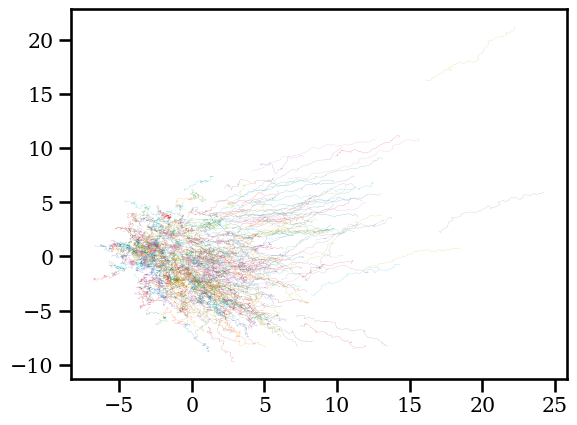

In [10]:
tmp_trajs = conditional_trajectories(dataset, mode="test")
tmp_schedule = torch.from_numpy(extended_t_schedule(dataset.config.inference_steps, .49, 1.)).float()
plt.plot(*np.einsum("ijk->kij", project(sampling(torch.from_numpy(tmp_trajs[50]).float().to(DEVICE), dataset.model, dataset.diffusivity, tmp_schedule.shape[0]-1, tmp_schedule, return_traj=True))), lw=.1);

Conditional paths (6)


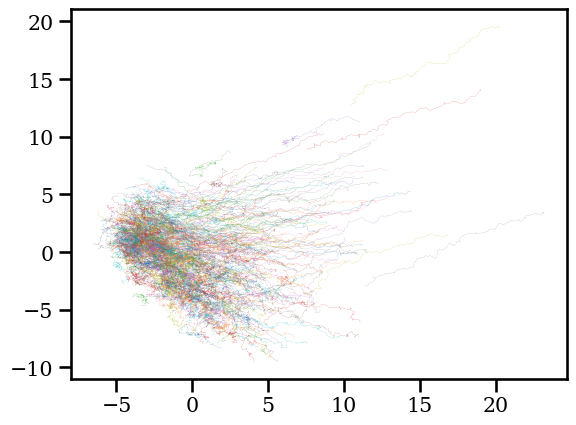

In [11]:
print("Conditional paths (6)")
plt.plot(*np.einsum("ijk->kij", project(conditional_trajectories(dataset, mode="test"))), lw=.1);

Unconditional paths (5)


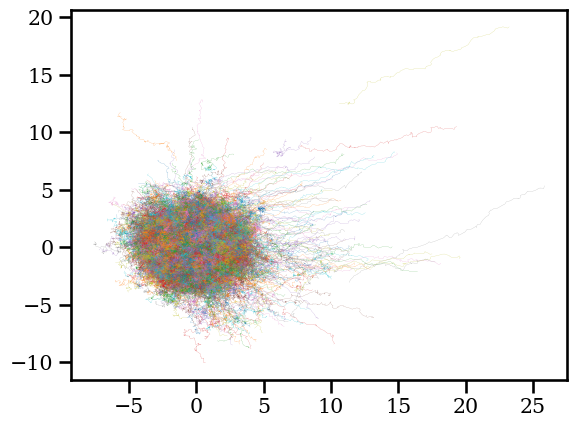

In [12]:
print("Unconditional paths (5)")
plt.plot(*np.einsum("ijk->kij", dataset.sample(mode="test")), lw=.1);

In [13]:
def vectorized_estimate_end_expectation(self, pos, pos_T, t):
    pos_T = pos_T.to(DEVICE)
    tmp_schedule = extended_t_schedule(self.config.inference_steps, t, 1.)
    if not isinstance(tmp_schedule, torch.Tensor):
        tmp_schedule = torch.from_numpy(tmp_schedule)
    tmp_schedule = tmp_schedule.float()

    # Sample 'expectation_reps' trajectories for each position in 'pos'
    expectation_reps = 20
    init_pos = torch.repeat_interleave(pos, expectation_reps, axis=0).float().to(DEVICE)
    # assert init_pos.shape == (pos.shape[0] * expectation_reps, pos.shape[1])

    sampled_endpoints = diff_unconditional_sampling(init_pos, self.model, self.diffusivity, self.config.inference_steps, tmp_schedule)

    end_pos = torch.repeat_interleave(pos_T, expectation_reps, axis=0)
    tau = 1.
    all_vals = torch.exp(- 1/(2*tau) * torch.square((end_pos - sampled_endpoints)).sum(axis=-1))

    # Compute empirical average
    doob_h_vals = all_vals.reshape((pos.shape[0], expectation_reps, -1)).mean(axis=1)

    return doob_h_vals

In [17]:
time_steps = range(0, 101, 15)
h_exp_mean_magnitude_by_time = np.array([vectorized_estimate_end_expectation(dataset, torch.from_numpy(tmp_trajs[k,::10]), torch.from_numpy(tmp_trajs[100,::10]), torch.tensor(k/100)).detach().cpu().mean() for k in time_steps])

In [31]:
pd.DataFrame(h_exp_mean_magnitude_by_time, index=map(lambda x: x/100, time_steps), columns=["Mean $h$ value"]).T

,0.00,0.15,0.30,0.45,0.60,0.75,0.90
Mean $h$ value,2.919826e-14,4.029725e-13,2.536141e-11,1.717318e-09,1.468964e-07,0.000027,0.008535
